Importing required Libraries


In [1]:
import numpy as np

import gym

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


c:\Users\Asus\anaconda3\envs\rl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model Architecture

In [2]:
# neural network model
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)  


Action selection step


In [3]:
def action_selection_policy(q_network, state, epsilon, n_actions):
    # Exploration step below

    if np.random.random() < epsilon:
        final_action = np.random.choice(n_actions)
        return final_action  
    

    # Exploitation step
    else:
        # converting tensor 
        state_tensor = torch.FloatTensor(state).unsqueeze(0)  

        q_values = q_network(state_tensor)

        final_action2 = torch.argmax(q_values).item()  
        return final_action2

Normalizing the data

In [4]:
def scale_state(state, scaler):

    # states are 2 dimentional
    state = np.array(state).reshape(1, -1)  
    
    transformed = scaler.transform(state)[0]  
    return transformed


For Non-linear function approximation, SARSA is selected.

SARSA function

In [5]:
def sarsa_model(env, episodes, alpha, gamma, epsilon):

    # State space and actions space
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Initializing the model
    q_network = QNetwork(state_size, action_size)

    #Optimizer, here Adam is used
    optimizer = optim.Adam(q_network.parameters(), lr=alpha)

    # Error calculation
    criterion = nn.MSELoss()  

    reward_episode = []

    # Standardizing the state
    scaler = StandardScaler()
    scaler.fit([env.observation_space.low, env.observation_space.high])

    for episode in range(episodes):
        state, _ = env.reset()
        state = scale_state(state, scaler)
        done = False
        total_reward = 0


        # selecting the action
        action = action_selection_policy(q_network, state, epsilon, action_size)

        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_state = scale_state(next_state, scaler)

            # Next action selection
            next_action = action_selection_policy(q_network, next_state, epsilon, action_size)

            # converting state to tensor
            state_tensor = torch.FloatTensor(state).unsqueeze(0) 

            # Q-value
            q_values = q_network(state_tensor)

            with torch.no_grad():
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
                next_q_values = q_network(next_state_tensor)

            q_current = q_values[0, action]
            
            if not done:
                q_next = next_q_values[0, next_action] 
            else: 
                0

            td_target = reward + gamma * q_next

            # Converting target to float
            if isinstance(td_target, float):
                td_target = torch.tensor(td_target).float()  

            # Loss calculation
            loss = criterion(q_current, td_target)  

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state, action = next_state, next_action
            total_reward += reward

        reward_episode.append(total_reward)

        # Print progress every 100 episodes
        if episode % 100 == 0:
            print(f"Episode {episode}/{episodes} complete.")

    return q_network, reward_episode

Cartpole-v1 Environment

In [6]:
env = gym.make("CartPole-v1")  

Hyperparameter

In [7]:
#Epoches/episodes
episode = 800

#Learning Rate
alpha = 0.1

# Discount Factor
gamma = 0.99 

# Exploration Rate
epsilon = 0.2 



Final training

In [8]:
q_network, episode_reward = sarsa_model(env, episode, alpha, gamma, epsilon)

Episode 0/800 complete.
Episode 100/800 complete.
Episode 200/800 complete.
Episode 300/800 complete.
Episode 400/800 complete.
Episode 500/800 complete.
Episode 600/800 complete.
Episode 700/800 complete.


Code for ploting average reward vs episodes

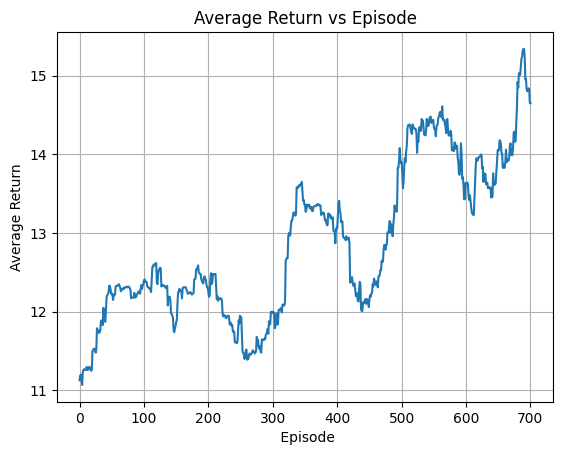

In [9]:
def avg_return_plot(episode_reward, w_size=100):
    
    avg_return = np.convolve(episode_reward, np.ones(w_size) / w_size, mode='valid')
    plt.plot(avg_return)
    plt.xlabel(' Episode')
    plt.ylabel('Average Return')
    plt.title(f'Average Return vs Episode')

    plt.grid(True)
    plt.show()

# Plotting the results after training
avg_return_plot(episode_reward)